# Clustering K-meains + PCA

### PA Women in Tech

## Dataset description

The [dataset](https://archive.ics.uci.edu/ml/datasets/HCV+data) that contains laboratory information about blood donor samples and whether they have Hepatitis. Machine learning techniques have been used with this dataset to generate laboratory diagnostic pathways.

The blood samples are categorised: each is either suitable for donation ('Blood Donor'), possibly suitable for donation 'suspect Blood Donor' or has been found to have Hepatitis. If Hepatitis, the disease's progress is also categorised: 'just' Hepatitis C, Fibrosis or Cirrhosis.

All attributes except `Category` and `Sex` are numerical. The 'laboratory' data are the attributes 5-14.
1. X (Patient ID/No.)
2. Category (diagnosis) (values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')
3. Age (in years)
4. Sex (f, m)
5. ALB
6. ALP
7. ALT
8. AST
9. BIL
10. CHE
11. CHOL
12. CREA
13. GGT
14. PROT

First, we'll import all the packages that we need:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

## Loading the data

1a. Load the dataset `hcv_data.csv` into a dataframe called `df_hcv` (HCV stands for Hepatitis C Virus)

In [32]:
df_hcv = pd.read_csv("hcv_data.csv")

1b. Display the first 5 rows of the dataframe

In [33]:
df_hcv.head()

,X,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


## Data exploration and cleaning


We aren't interested in the id column, X, as this is not relevant to the properties of the blood.

2a. Drop the id column from the dataframe

In [34]:
df_hcv = df_hcv.drop(['X'], axis = 1)

2b. Perform some quick statistical analysis on the dataframe

In [5]:
df_hcv.describe()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,47.408130,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,10.055105,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,39.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,47.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,54.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


2c. Check for missing values in the dataframe

In [6]:
df_hcv.isna().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

2d. Replace all missing values in the dataframe with the mean

In [35]:
df_hcv = df_hcv.fillna(df_hcv.mean(numeric_only=True))

Text(0.5, 0.98, 'AST values within Categories of Blood')

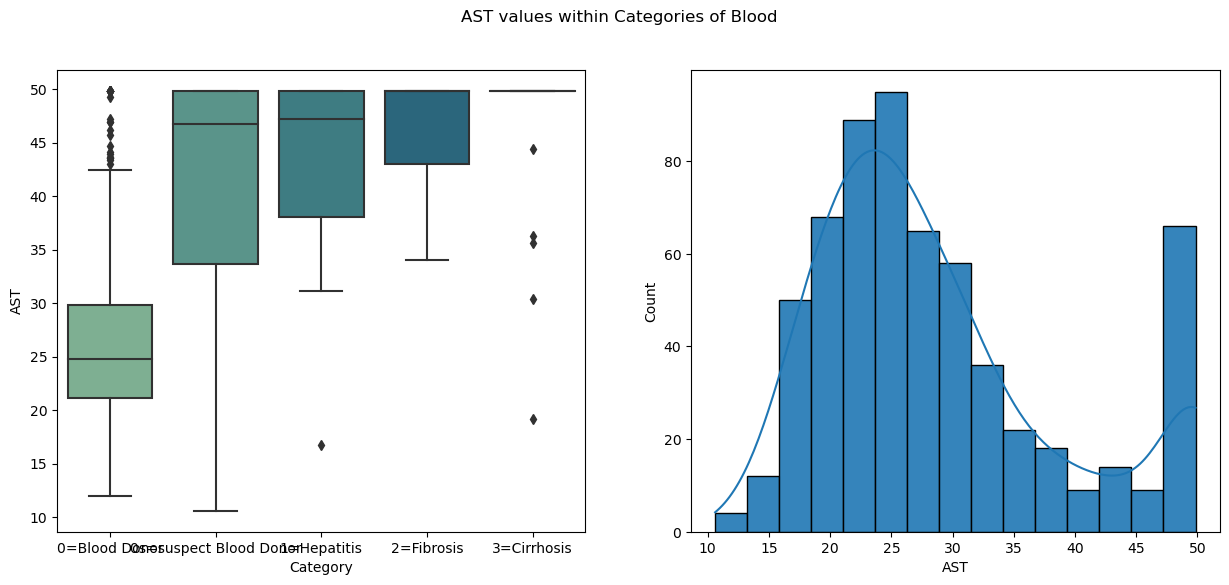

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(x='Category', y = "AST", data=df_hcv, palette="crest", ax=ax[0])
sns.histplot(df_hcv["AST"], kde=True, alpha=0.9, ax=ax[1])

fig.suptitle('AST values within Categories of Blood')

##  Removing outliers

Clustering is sensitive to outliers and hence we need to identify and remove them.

We will use _interquartile_ range based outlier detection.

#### Quartiles

Quartiles are three values that split your dataset into quarters.

These values are the following:

* Q1 First quartile: 25% of the data are below this value
* Q2: Second quartile (median): This value splits the data in half
* Q3 Third quartile: 25% of the data are above this value

![title](https://i0.wp.com/statisticsbyjim.com/wp-content/uploads/2022/03/Quartiles.png?w=576&ssl=1)

Read more [here](https://statisticsbyjim.com/basics/quartile/).

#### Interquartile range

The _interquartile range_ (IQR) is a measure of variability. It is the range between the first and third quartiles.

To use the quartiles to help find outliers, we find the lower and upper 'fences'. Values below the lower fence and above the upper fence are potential outliers that you should investigate.

Fences are usually found with the following formulas:

* Lower fence: Q1 – (1.5 * IQR)
* Upper fence: Q3 + (1.5 * IQR)

The function below returns these values (make sure you run the cell):

In [46]:
def return_interquartile_min_max(input_list):
    
    Q1 = np.percentile(input_list, 25)
 
    Q3 = np.percentile(input_list, 75)

    IQR = Q3 - Q1

    low = Q1 - 1.5*IQR

    high = Q3 + 1.5*IQR
    
    return low, high

We will replace all values below the lower fence with the lower fence value, and all values above the upper fence with the upper fence value.

We only want to do this for numerical columns of course. Below, we define a list of relevant column names (filtering out 'Category' and 'Sex'):

In [47]:
num_col_names = [x for x in df_hcv.columns if x not in ['Category', 'Sex']]

3. Replace all the outliers in the dataframe as described above.

You should:
1. Loop through each of the numerical columns (use the above defined list)
2. For each column, find the lower and upper fence using the `return_interquartile_min_max` function
3. Check each value in the column, replacing with the lower or upper fence if necessary

To apply a function to every value in a dataframe, you can use the [`.apply()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method. The function can either be a standard Python function, or you can use a [Python lambda function](https://www.programiz.com/python-programming/anonymous-function).



In [48]:
for i in num_col_names:
    this_low, this_high = return_interquartile_min_max(df_hcv[i])
    df_hcv[i] = df_hcv.apply(lambda x: this_low if x[i] <= this_low else x[i], axis = 1)
    df_hcv[i] = df_hcv.apply(lambda x: this_high if x[i] >= this_high else x[i], axis = 1)

<Axes: >

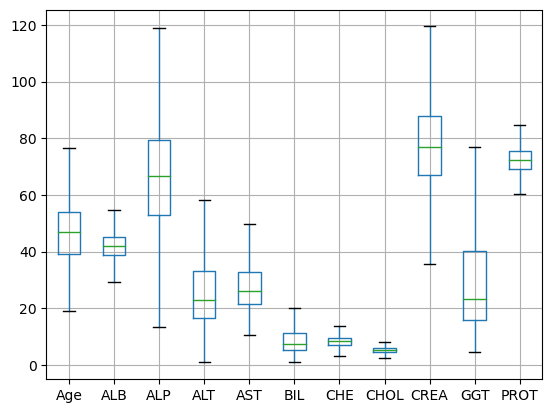

In [52]:
df_hcv.boxplot(num_col_names)

• There are no more outliers in the numerical columns 

## Data pre-processing

All numeric columns are on different scales and require scaling.

4. Use the `num_col_names` list to standardise all the numerical columns.

In [11]:
df_hcv[num_col_names] = StandardScaler().fit_transform(df_hcv[num_col_names])

## PCA

PCA is a dimensionality reduction technique; we will now apply PCA to the numerical columns of the dataset. 

It is ideal to retain 90% to 99% of the variance in your data. When creating the PCA object, instead of specifying the number of principal components we want, we can also instead specify the minimum amount of variance we'd like to retain. We can do this by setting `0 < n_components < 1`, e.g. `n_components=0.8` will retain 80% of the variance.

5. Apply PCA on the numerical columns of data, retaining 90% of the variance

In [12]:
pca = PCA(n_components = 0.90)
pc_df = pd.DataFrame(pca.fit_transform(df_hcv[num_col_names]))

We can plot the explained variance of each principal component like so:

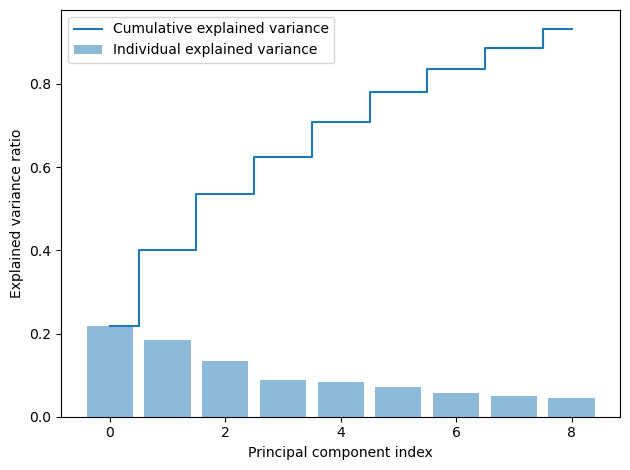

In [13]:
# For this code to work, your above created PCA object must be called pca
exp_var_pca = pca.explained_variance_ratio_
cumulative_sum_exp_var = np.cumsum(exp_var_pca)

plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0, len(cumulative_sum_exp_var)), cumulative_sum_exp_var, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

##  Finding k

Now we will use the elbow method to find the optimal number of clusters, k.

6a. Create a list of distortion values for KMeans cluster k values between 1 and 9.

In [14]:
cluster_distortion = []
for i in range(1, 10):
    kmeans = KMeans(i)
    kmeans.fit(pc_df)
    cluster_distortion.append(kmeans.inertia_)

/Users/maria/opt/anaconda3/envs/wit-python-ds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/maria/opt/anaconda3/envs/wit-python-ds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/maria/opt/anaconda3/envs/wit-python-ds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/maria/opt/anaconda3/envs/wit-python-ds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

6b. Plot the distortion values against the k values.

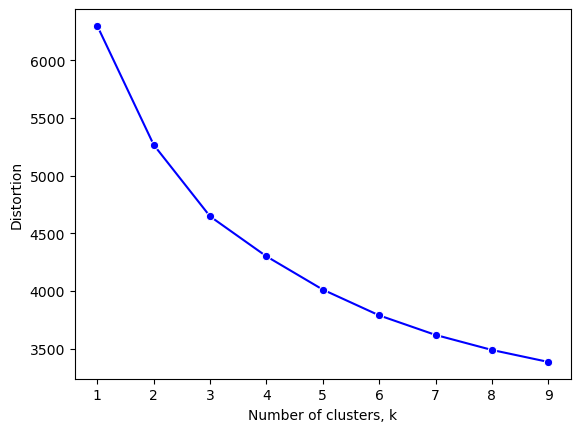

In [15]:
sns.lineplot(x=range(1, 10), y=cluster_distortion, marker='o',color='blue')
plt.xlabel('Number of clusters, k')
plt.ylabel('Distortion')
plt.show()

There is no clear elbow point in this figure and so we will analyse 3, 4 and 5 clusters.

##  K-means clustering

7a. Apply k-means clustering to the data with 3 clusters.

In [16]:
kmeans = KMeans(3)
y_kmeans = kmeans.fit_predict(pc_df)

/Users/maria/opt/anaconda3/envs/wit-python-ds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


We can create a scatter plot with colours for the two first principal components (column names `0` and `1`). It's important to note however, that these two components only give us about _40%_ of the information in the data (from the PCA graph earlier), so it's not a great way to visualise it. It's quite straight-forward though, and we can still use it to compare the k = 4 and k = 5 clustering.

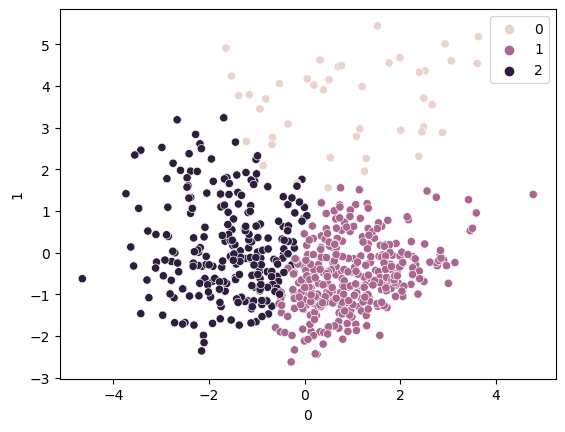

In [17]:
sns.scatterplot(data=pc_df, x=0, y=1, hue=kmeans.labels_)
plt.show()

7b. Apply k-means clustering for both 4 and 5 clusters, visualising them both for the first two principal components.

/Users/maria/opt/anaconda3/envs/wit-python-ds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


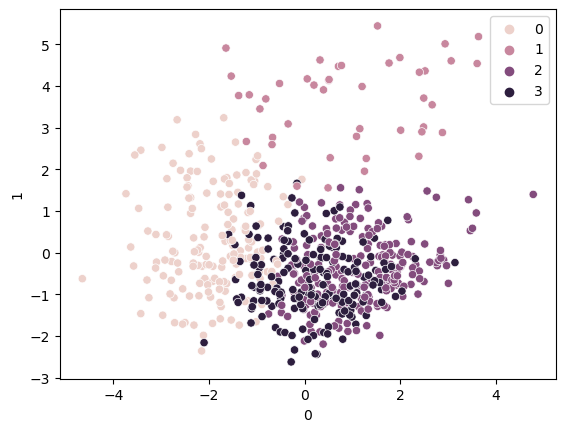

In [18]:
kmeans = KMeans(4)
y_kmeans = kmeans.fit_predict(pc_df)

sns.scatterplot(data=pc_df, x=0, y=1, hue=kmeans.labels_)
plt.show()

/Users/maria/opt/anaconda3/envs/wit-python-ds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


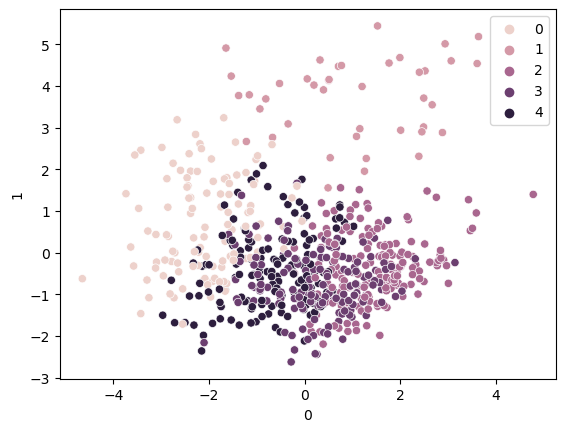

In [19]:
kmeans = KMeans(5)
y_kmeans = kmeans.fit_predict(pc_df)

sns.scatterplot(data=pc_df, x=0, y=1, hue=kmeans.labels_)
plt.show()

7c. Plot a scatterplot of the first two principal components, with hue as the original dataframe's `Category` column.

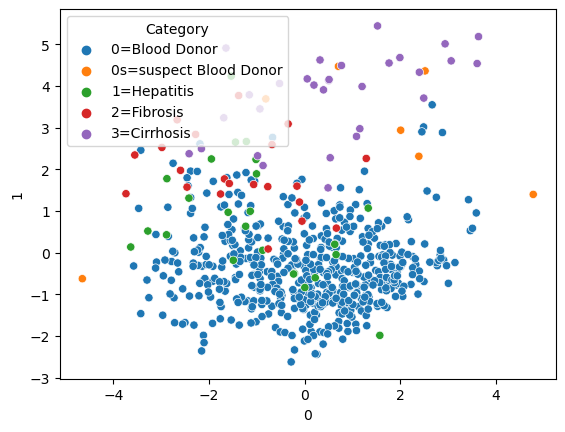

In [20]:
sns.scatterplot(data=pc_df, x=0, y=1, hue=df_hcv["Category"])
plt.show()

In some cases we might not be able to clearly distinguish between the various clusters. This can occur for a number of reasons:
  * The first two Principal Components is not be able to explain the variance of the higher dimension dataset well enough
  * The features might not have the predictive power to diferrentiate the data
  * We might need to do some feature engineering to create/remove features that will add value to our model
  * We might have some anomalies in our dataset which we will need to remove
  
How do we approach this problem?
  * We could perform a logistic regression on the data and look on the feature importance on the final results (category). Which features are good predictors of the target variable? 
  * We could redo clustering again after feature engineering and after obtaining a better understanding of our data
  * We could use PCA with more Principal Components. We want to have a good capture of the data variability. Or even to not do it at all!
  * We might try and obtain more data - the vast majority of the dataset is in the same category (Blood donor). It would be useful if we had more datapoints for the other categories